# Prova eEDB-002/2024-3

Importando bibliotecas necessárias para o desenvolvimento da prova. Os principais\
pacotes são [sklearn](https://scikit-learn.org/stable/) para treinamento do modelo; [numpy](https://numpy.org/) e [pandas](https://pandas.pydata.org/) para manipulação\
de dados e; [seaborn](https://seaborn.pydata.org/) e [matplotlib](https://matplotlib.org/) para geração de visualizaçãoes.

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

---
## Leitura dos dados

Importando dados em formato .xlsx para realizar a prova, considerando:
- Importando apenas a primeira pasta do arquivo "Question 1";
- ignorando as primeiras 18 linhas do arquivo (contando a partir de 0);
- Discriminando os valores faltantes "\<NA\>" e "?";
- Renomeando as colunas para _snake case_;
- Selectionando apenas as colunas desejadas "date", "total_sales" e "temperature_celsius";
- Convertendo o tipo das colunas para um mais apropriado.

In [5]:
ice_cream_sales = pd.read_excel(
    io='../data/eDB-002 - Exercicio - REG LINENAR.xlsx',
    sheet_name='Question 1',
    skiprows=18,
    na_filter=True,
    na_values=['<NA>', '?'],
    names=['date', 'temperature_fahrenheit', 'total_sales', 'temperature_celsius'],
    usecols=['date', 'total_sales', 'temperature_celsius'],
    dtype={
        'date': 'datetime64[ns]',
        'total_sales': pd.Float64Dtype(),
        'temperature_celsius': pd.Int64Dtype(),
    },
)

Removendo linhas com dados faltantes

In [6]:
ice_cream_sales.dropna(inplace=True)

Visualizando dados lidos do arquivo .xlsx

In [7]:
ice_cream_sales.head()

,date,total_sales,temperature_celsius
0,2004-03-01,38911.0,24
1,2004-03-02,36337.258058,23
2,2004-03-03,35728.110238,22
3,2004-03-04,36945.386701,24
4,2004-03-05,36335.166206,23


Conferindo tipo dos dados

In [8]:
ice_cream_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7175 entries, 0 to 7174
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 7175 non-null   datetime64[ns]
 1   total_sales          7175 non-null   Float64       
 2   temperature_celsius  7175 non-null   Int64         
dtypes: Float64(1), Int64(1), datetime64[ns](1)
memory usage: 238.2 KB


---
## Engenharia de características (variáveis)

### 1) Criação de variaveis

#### 1.1) Crie uma variavel chamada: dia_da_semana e popule-na com (dom, seg, ter, etc)

**OBS**: por se tratar de uma variável **qualitativa ordinal**, assim como para facilitar a compreensão dos dados pelo modelo,\
preferiu-se adotar numeros naturais de 0 a 6, em que 0 representa a segunda-feira; 6, domingo.

In [39]:
ice_cream_sales['day_of_week'] = ice_cream_sales['date'].dt.strftime('%A')
ice_cream_sales.head()

,date,total_sales,temperature_celsius,day_of_week,month_of_year
0,2004-03-01,38911.0,24,Monday,3
1,2004-03-02,36337.258058,23,Tuesday,3
2,2004-03-03,35728.110238,22,Wednesday,3
3,2004-03-04,36945.386701,24,Thursday,3
4,2004-03-05,36335.166206,23,Friday,3


#### 1.2) Crie uma variavel chamada: mês_venda e popule-na com (jan,fev,mar,abr, etc)

**OBS**: por se tratar de uma variável **qualitativa ordinal**, assim como para facilitar a compreensão dos dados pelo modelo,\
preferiu-se adotar numeros naturais de 1 a 12, em que 1 representa Janeiro; 12, Dezembro.

In [40]:
ice_cream_sales['month_of_year'] = ice_cream_sales['date'].dt.strftime('%B')
ice_cream_sales.head()

,date,total_sales,temperature_celsius,day_of_week,month_of_year
0,2004-03-01,38911.0,24,Monday,March
1,2004-03-02,36337.258058,23,Tuesday,March
2,2004-03-03,35728.110238,22,Wednesday,March
3,2004-03-04,36945.386701,24,Thursday,March
4,2004-03-05,36335.166206,23,Friday,March


---
## Análise exploratória

### 2) Análises univariadas

#### 2.1) Análises descritivas

Calculando a quantidade de registros, média, desvio padrão, mínimo, máximo e os quartis\
para as variáveis quantitativas contínuas, i.e., "total_sales" e "temperature_celsius".

In [41]:
ice_cream_sales.drop(columns=['date', 'day_of_week', 'month_of_year']).describe()

,total_sales,temperature_celsius
count,7175.0,7175.0
mean,40154.737143,25.427735
std,5642.698863,6.293561
min,28238.199588,11.0
25%,36365.003731,21.0
50%,39052.56443,24.0
75%,45451.687339,31.0
max,55022.578795,42.0


#### 2.2) Analise graficas

Gráfico de violino com boxplot para descrever a distribuição de vendas de sorvete

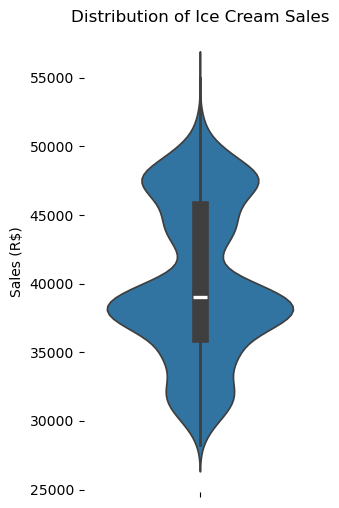

In [125]:
plt.subplots(figsize=(3, 6))

sns.violinplot(
    data=ice_cream_sales,
    y='total_sales',
    inner_kws=dict(box_width=12, whis_width=2)
)

plt.ylabel('Sales (R$)')
plt.title('Distribution of Ice Cream Sales')

sns.despine(left=True, bottom=True)

Gráfico de violino com boxplot para descrever a distribuição de temperatudas aferidas diariamente

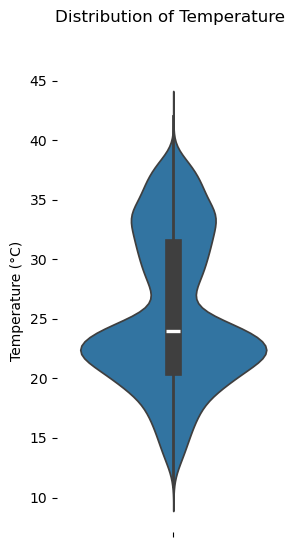

In [126]:
plt.subplots(figsize=(3, 6))

sns.violinplot(
    data=ice_cream_sales,
    y='temperature_celsius',
    inner_kws=dict(box_width=12, whis_width=2)
)

plt.ylabel('Temperature (°C)')
plt.suptitle('Distribution of Temperature')

sns.despine(left=True, bottom=True)

Analise a distribuição de dados em relação ao total de vendas por meio de uma função de\
densidade de probabilidade, em que a área de figura resulta em $1$.

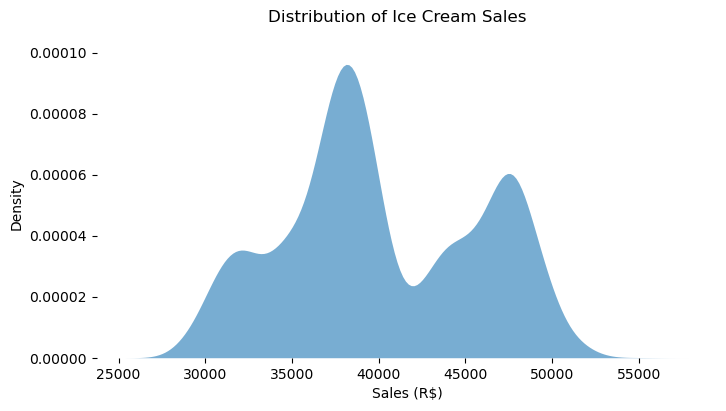

In [108]:
plt.subplots(figsize=(8, 4))

sns.kdeplot(
   data=ice_cream_sales,
   x='total_sales',
   fill=True,
   alpha=.6,
   linewidth=0,
   common_norm=True,
)

plt.xlabel('Sales (R$)')
plt.suptitle('Distribution of Ice Cream Sales')

sns.despine(left=True, bottom=True)

Analise a distribuição de dados em relação ao temperatura (celsius) por meio de uma função de\
densidade de probabilidade de probabilidade,em que a área de figura resulta em $1$.

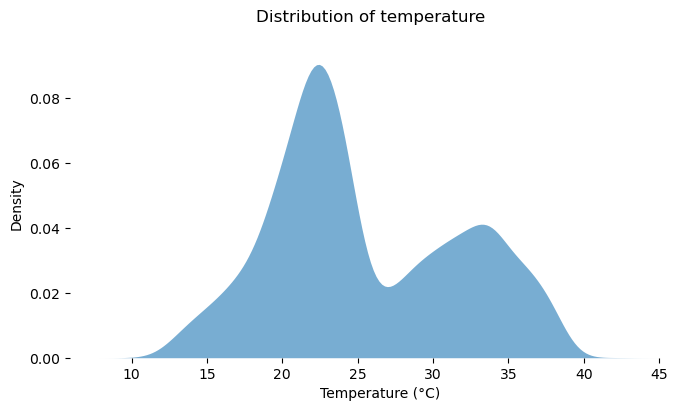

In [109]:
plt.subplots(figsize=(8, 4))

sns.kdeplot(
   data=ice_cream_sales,
   x='temperature_celsius',
   fill=True,
   alpha=.6,
   linewidth=0,
   common_norm=True,
)

plt.xlabel('Temperature (°C)')
plt.suptitle('Distribution of temperature')

sns.despine(left=True, bottom=True)

### 3) Análises bi-variadas

#### 3.1) Análise de vendas em relação a datas do ano

Analise sobre total de vendas em relação ao mês do ano. Neste contexto foi utilizado um\
gráfico de violino em que a linha tracejada ao meio representa a mediana; linha a cima o\
terceiro quartil; linha abaixo, primeiro quartil.

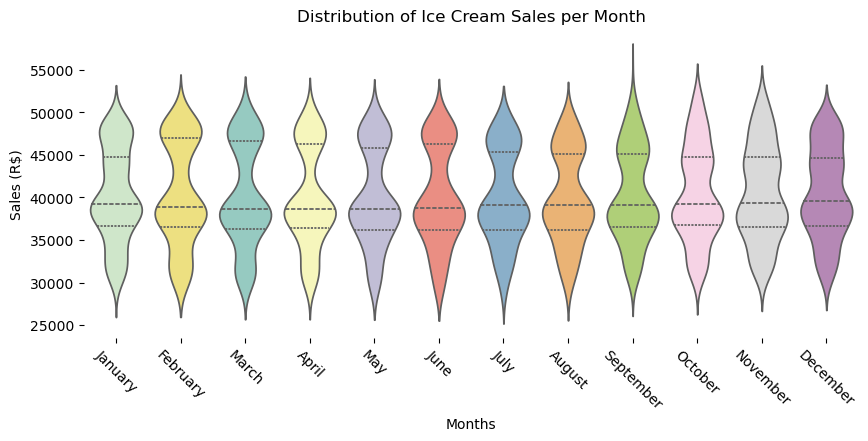

In [91]:
plt.subplots(figsize=(10, 4))

sns.violinplot(
    data=ice_cream_sales,
    x='month_of_year',
    y='total_sales',
    hue='month_of_year',
    palette='Set3',
    legend=False,
    inner='quart',
    order=[
        'January',
        'February',
        'March',
        'April',
        'May',
        'June',
        'July',
        'August',
        'September',
        'October',
        'November',
        'December'
    ]
)

plt.xticks(rotation=-45)
plt.xlabel('Months')
plt.ylabel('Sales (R$)')
plt.title('Distribution of Ice Cream Sales per Month')

sns.despine(left=True, bottom=True)

Analise sobre total de vendas em relação ao dia da semana. Neste contexto foi utilizado um\
gráfico de violino em que a linha tracejada ao meio representa a mediana; linha a cima o\
terceiro quartil; linha abaixo, primeiro quartil.

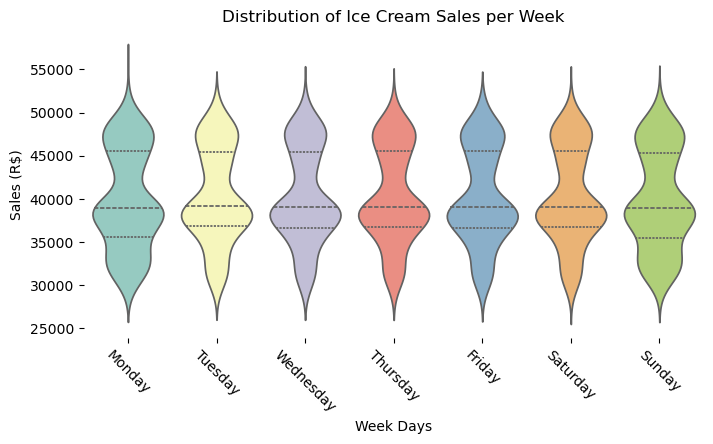

In [90]:
plt.subplots(figsize=(8, 4))

sns.violinplot(
    data=ice_cream_sales,
    x='day_of_week',
    y='total_sales',
    hue='day_of_week',
    palette='Set3',
    legend=False,
    inner='quart',
    order=[
        'Monday',
        'Tuesday',
        'Wednesday',
        'Thursday',
        'Friday',
        'Saturday',
        'Sunday'
    ]
)

plt.xticks(rotation=-45)
plt.xlabel('Week Days')
plt.ylabel('Sales (R$)')
plt.title('Distribution of Ice Cream Sales per Week')

sns.despine(left=True, bottom=True)

#### 3.2)  Analise graficas bi variadas quanto à vendas e temperatura

Análise por meio de um gráfico de dispersão, com sua variante "hexagon bins", a qual\
agrupa os pontos (venda por temperatura) em hexágonos, ao passo que a cor mais escura\
indica maior concentração de pontos no hexágono em questão; clara, menor concentração.\
Além disso, cada variável contínua tem seu histograma calculado para adicionar informações\
que facilitam a análise uni e bi-variada.

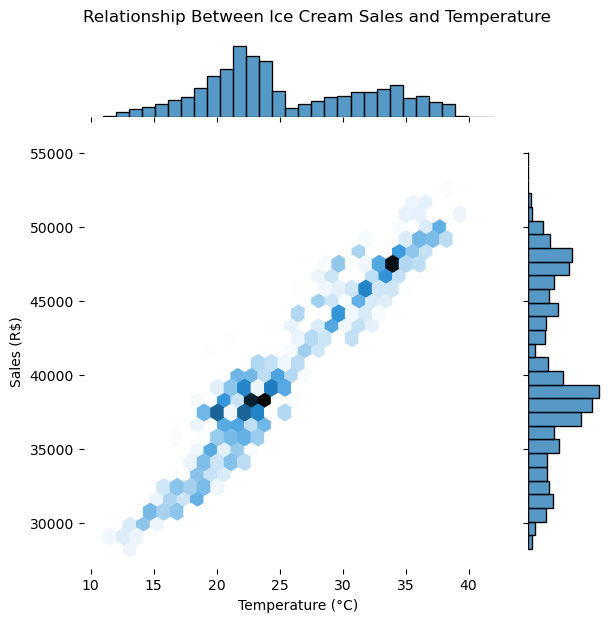

In [102]:
sns.jointplot(
   data=ice_cream_sales,
   y='total_sales',
   x='temperature_celsius',
   kind='hex',
   height=6,
)

plt.xlabel('Temperature (°C)')
plt.ylabel('Sales (R$)')
plt.suptitle('Relationship Between Ice Cream Sales and Temperature', y=1.03)

sns.despine(left=True, bottom=True)

### 3.3) Calcule a correlação entre as variaveis _temperatura_ e _total de itens vendidos_

In [105]:
numeric_variabels = ice_cream_sales.drop(columns=['day_of_week', 'month_of_year'])
correlations = numeric_variabels.corr(method='pearson')
correlations.loc['total_sales', 'temperature_celsius']

0.9661052487332045

---
## Análise preditiva

### 4) Defindo modelo de prediçãoa por meio uma Regressão Linear com penalização $\ell_1$

Foi utilizado o modelo de [Regressão Lasso](https://scikit-learn.org/stable/modules/linear_model.html#lasso) (_Least Absolute Shrinkage and Selection Operator_), o qual consiste em\
aplicar uma regressão linear adicionando em sua função custo uma penalização $\ell_1$ para os coeficientes $\beta$.\
Isto faz com que os coeficientes lineares $\beta$ não significativos para predizer nossa variável dependente $y$ sejam\
reduzidos à zero. Isto acontece pois com a penalização $\ell_1$ penaliza valores altos para os coeficientes $\beta$, o que pode\
ser intensificado ao não pela constante $\alpha$; isto é, quanto maior o valor de $\alpha$, maior a penalização. Além disso, caso o\
valor de $\alpha$ tenda ao infinito, assintoticamente nossa função tenderá a um valor constante, o que representa, na prática,\
que o modelo se torna insensível à mudanças nas variáveis indepentestes ($x$).Dito isto, a escolha pela regressão Lasso \
deu-se um vez que o modelo de predição receberá três características, variáveis independentes, quais sejam: temperatura (°C),\
dia da semana e mês. Logo, a fim de encontrar quais variáveis independentes são mais significativas para o modelo de predição,\
optou-se pela Regressão Lasso em virtudo de sua capacidade de selecionar as variáveis mais significativas,descartando as\
variáveis menos significativas, ou reduzindo o valor de seus pesos $\beta$ para o cálculo final da variável dependente.

Assim, para além de encontrar a função que preverá o total de vendas de sorvete, a Regressão Lasso se utiliza a equação\
abaixo para encontrar as variáveis independentes mais significativas para o modelo, por meio da otimização dos coeficientes\
lineares $\beta$ que minimizem o valor de custo $J$. O custo $J$ é então calculado pela soma dos resísudos ao quadrado, isto é, a \
direfenteça entra o valor predito $\hat{y}$ com o valor real $y$, acrecido da penalização $\ell_1$ dos coeficientes lineares $\beta$. Além disso,\
especificamente na implementação da regressão Lasso da biblioteca [sk-learning](https://scikit-learn.org/stable/modules/linear_model.html#lasso) a soma dos resíduos ao quadrado é\
normalizada pela quantidade $n$ de variáveis indepentes $x$, para que o custo não diverja para conjuntos de dados com tamanhos distindos.\
Por fim a quantidade de variáveins independentes $n$ é multiplicado por $2$ para simplificar o cálculo da derivda da função custo $J$.

$
J(\beta) = \min\limits_{\beta \in \mathbb{R}^p} \{ \frac{1}{2n} ||y - \beta_0 - X\beta||^2_2 + \alpha ||\beta||_1 \}
$

Selecionando entrada do modelo

In [127]:
X = ice_cream_sales.loc[:, ['date', 'temperature_celsius']]
y = ice_cream_sales.loc[:, ['total_sales']].values.ravel()

Dividindo dados entre conjunto de trainamento (80%) e teste (20%)

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Criando função para extrair dia da semana e dia do mês da data de aferição

In [129]:
def get_date_features(X: pd.DataFrame) -> pd.DataFrame:
    """
    A function to extract the day of week and the month of the year
    from a given date
    """
    X['day_of_week'] = X['date'].dt.day_of_week
    X['month_of_year'] = X['date'].dt.month
    X = X.drop(columns=['date'])
    
    return X

date_features = FunctionTransformer(get_date_features, validate=False)

Criando conjunto de transformações sequenciais dos dados, isto é, primeiro se extrai características baseadas na data de aferição, e então é aplicado um normalizador (de 0 a 1) em todos os dados

In [21]:
pipe = Pipeline([ ('date_features', date_features) ])

Salvando pipeline de dados

In [22]:
joblib.dump(pipe, '../pipeline/ice-cream-sales-pipeline.joblib')

['../pipeline/ice-cream-sales-pipeline.joblib']

Ajustando dados de treinamento e aplicando transformações, posteriormente transformando dados de teste

In [23]:
X_train_pre = pipe.fit_transform(X_train)
X_test_pre = pipe.transform(X_test)

Treinando modelo de regressão linear com penalização L1 e L2, conhecido como ElasticNet

In [32]:
grid_serch = GridSearchCV(
    estimator=Lasso(), 
    param_grid={'alpha': np.arange(0.1, 100.1, 0.1)}, 
    cv=10,
    scoring='neg_root_mean_squared_error', 
    verbose=3,
    n_jobs=-1, 
    refit=True
)

In [33]:
grid_serch.fit(X_train_pre, y_train)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


GridSearchCV(cv=10, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': array([  0.1,   0.2,   0.3,   0.4,   0.5,   0.6,   0.7,   0.8,   0.9,
         1. ,   1.1,   1.2,   1.3,   1.4,   1.5,   1.6,   1.7,   1.8,
         1.9,   2. ,   2.1,   2.2,   2.3,   2.4,   2.5,   2.6,   2.7,
         2.8,   2.9,   3. ,   3.1,   3.2,   3.3,   3.4,   3.5,   3.6,
         3.7,   3.8,   3.9,   4. ,   4.1,   4.2,   4.3,   4.4,   4.5,
         4.6,   4.7,   4.8,   4.9,   5. ,   5.1,   5.2,   5.3,   5.4,
         5.5,   5.6,   5.7,   5.8,   5.9,   6. ,   6.1,   6.2,   6.3,
         6.4,   6.5,   6.6,   6.7,   6.8,   6.9,   7. ,   7.1...
        93.7,  93.8,  93.9,  94. ,  94.1,  94.2,  94.3,  94.4,  94.5,
        94.6,  94.7,  94.8,  94.9,  95. ,  95.1,  95.2,  95.3,  95.4,
        95.5,  95.6,  95.7,  95.8,  95.9,  96. ,  96.1,  96.2,  96.3,
        96.4,  96.5,  96.6,  96.7,  96.8,  96.9,  97. ,  97.1,  97.2,
        97.3,  97.4,  97.5,  97.6,  97.7,  97.8,  97.9,  98. ,  98.1,
        98.2,  98.3,  98.4,  98.5,  98.6,  98.7,  98.8,  98.9,  99. ,
        99.1,  99.2,  99.3,  99.4,  99.5,  99.6,  99.7,  99.8,  99.9,
       100. ])},
             scoring='neg_root_mean_squared_error', verbose=3)

Melhor modelo

In [34]:
grid_serch.best_params_

{'alpha': 28.300000000000004}

In [35]:
optimal_lasso = grid_serch.best_estimator_

Salvando melhor modelo

In [36]:
joblib.dump(optimal_lasso, '../model/optimal-lasso.joblib')

['../model/optimal-lasso.joblib']

Realizando predições de total de vendas

In [37]:
y_train_pred = optimal_lasso.predict(X_train_pre)
y_test_pred = optimal_lasso.predict(X_test_pre)

Métrica de R² para conjunto de trainamento

In [38]:
r2_score(y_train, y_train_pred)

0.9333518460684564

Métrica de R² para conjunto de teste

In [39]:
r2_score(y_test, y_test_pred)

0.9343511507038548

coeficientes para cada característica (X) juntamente com coeficiente de interseção com o eixo y

In [40]:
feature_coef = pd.DataFrame({
    'feature_names': ['temperature_celsius', 'day_of_week', 'month_of_year', 'y_intercept'],
    'coefficient': np.append(optimal_lasso.coef_, optimal_lasso.intercept_)
})

feature_coef

,feature_names,coefficient
0,temperature_celsius,865.572596
1,day_of_week,0.000000
2,month_of_year,-21.371048
3,y_intercept,18287.495458


A função que prevê o valor de vendas ($\hat{y}$) foi modelada com base na temperatura, dia da semana e mês do ano,\
por meio dos coeficientes angulares: $w_t$ que representa o coeficiente de temperatura; $w_d$, coeficiente de dia da semana e;\
$w_m$, coeficiente de mês do ano. Já o coeficiente linear é representado por $w_l$. Por fim, as variáveis utilizadas como entrada\
desta função são temperatura, dia da semana e mês do ano, repectivamente representados por $x_t$, $x_d$ e $x_m$.

$
\hat{y} = w_t * x_t + w_d * x_d + w_m * x_m + w_l \\
$

Após o treinamento do modelo, por meio da técnica de Regressão Lasso, os coeficientes obtidos foram:

$
w_t \; = 865.572596 \\
w_d \ = 0 \\
w_m = -21.371048 \\
w_l \; \ = 18287.495458
$

Ao fim do treinamento, foi obtido um $R_2$ de $0.9333518460684564$ para o conjunto de treinamento e\
um $R_2$ de $0.9343511507038548$ para o conjunto de tese.

## 5) Prevejam qual será o total a ser faturado com as vendas (em R$) na data de 30/out/23, sabendo que a previsao do tempo aponta para 18o C

Criando modelo automatizado que pega uma entrada de data e temperatura, transforma os dados e depois faz a predição

In [41]:
loaded_pipe = joblib.load('../pipeline/ice-cream-sales-pipeline.joblib')
loaded_model = joblib.load('../model/optimal-lasso.joblib')

In [54]:
def predict_sales(input_data: list[list]) -> list[float]:
    """
    A function to prepare the raw data to a proper way for prediction
    """
    instances = pd.DataFrame(data=input_data, columns=['date', 'temperature_celsius'])

    instances['date'] = instances['date'].astype('datetime64[ns]')
    instances['temperature_celsius'] = instances['temperature_celsius'].astype(pd.Int64Dtype())

    instances_preprocessed = loaded_pipe.transform(instances)
    prediction = loaded_model.predict(instances_preprocessed)

    return prediction.tolist()

In [55]:
input_data = [['30-10-2023', 18]]
predict_sales(input_data)

[33654.091698576594]

## 6) Escreva a sua conlusão

## 7) Escreva a sua recomendação para o Diretor Fianceiro desta empresa